# Import data from kaggle

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c shai-level-2-training-2023

100% 524M/526M [00:31<00:00, 18.7MB/s]
100% 526M/526M [00:31<00:00, 17.4MB/s]


In [ ]:
! unzip shai-level-2-training-2023.zip -d Data

Archive:  shai-level-2-training-2023.zip
  inflating: Data/sample_submission.csv  
  inflating: Data/test/040263.jpeg   
  inflating: Data/test/0621724.jpeg  
  inflating: Data/test/0777738.jpeg  
  inflating: Data/test/10256151.jpeg  
  inflating: Data/test/105615245.jpeg  
  inflating: Data/test/10674923.jpeg  
  inflating: Data/test/10779808.jpeg  
  inflating: Data/test/109152324.jpeg  
  inflating: Data/test/111993936.jpeg  
  inflating: Data/test/11352122.jpeg  
  inflating: Data/test/11545830.jpeg  
  inflating: Data/test/117560797.jpeg  
  inflating: Data/test/118551363.jpeg  
  inflating: Data/test/119145669.jpeg  
  inflating: Data/test/11971304.png  
  inflating: Data/test/120186574.jpeg  
  inflating: Data/test/12119481.png  
  inflating: Data/test/121283966.jpeg  
  inflating: Data/test/123325136.jpeg  
  inflating: Data/test/123789527.jpeg  
  inflating: Data/test/126307058.jpeg  
  inflating: Data/test/126768317.jpg  
  inflating: Data/test/127126503.jpeg  
  inflating: 

# import Libs

In [ ]:
import tensorflow as tf
from tensorflow import keras
import os 
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import cv2
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from google.colab.patches import cv2_imshow


In [ ]:
# function that would read an image provided the image path, preprocess and return it back

def read_and_preprocess(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR) # reading the image
    img = cv2.resize(img, (256, 256)) # resizing it (I just like it to be powers of 2)
    img = np.array(img, dtype='float32') # convert its datatype so that it could be normalized
    img = img/255 # normalization (now every pixel is in the range of 0 and 1)
    return img


In [ ]:
X = [] # To store train images
y = [] # To store train labels

# labels -
# 0 - covid
# 1 - normal
# 2 - virus

train_path = "/content/Data/train/" # path containing training image samples

In [ ]:
for folder in os.scandir(train_path):
    for entry in os.scandir(train_path + folder.name):

        X.append(read_and_preprocess(train_path + folder.name + '/' + entry.name))
        
        if folder.name[0]=='c':
            y.append(0)
        elif folder.name[0]=='v':
            y.append(1)
        else:
            y.append(2)

In [ ]:
X= np.array(X)
X.shape 

(1196, 256, 256, 3)

In [ ]:
y = np.array(y)
y.shape

(1196,)

## Visualizing the Dataset¶


<BarContainer object of 3 artists>

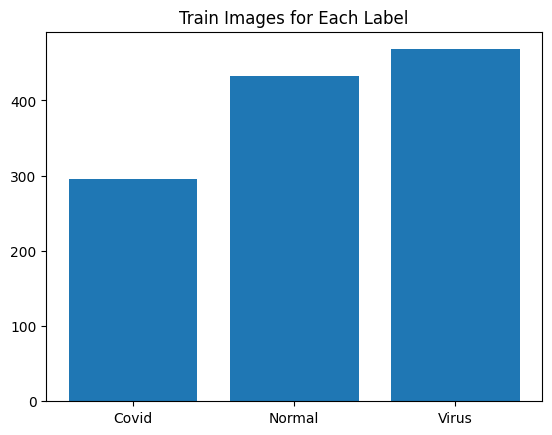

In [ ]:
covid_count = len(y[y==0])
normal_count = len(y[y==1])
virus_count = len(y[y==2])

plt.title("Train Images for Each Label")
plt.bar(["Covid", "Normal", "Virus"],[covid_count, normal_count, virus_count])

# We have more number of covid samples that Pneumonia and Normal

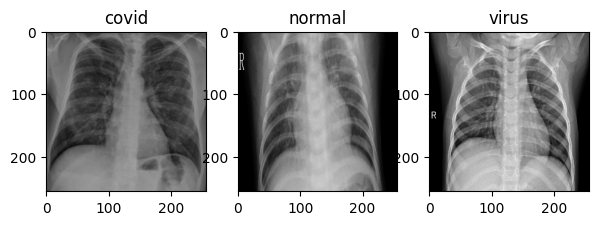

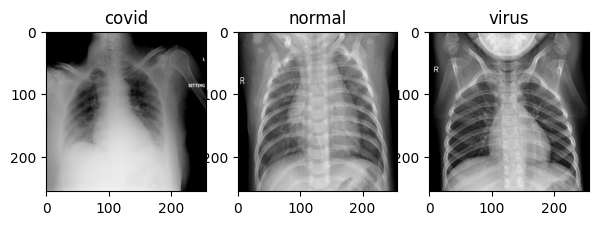

In [ ]:
# Plotting 2 images per disease

import random

title = {0:"covid", 1:"normal", 2:"virus"}

rows = 2
columns = 3

for i in range(2):
    
    fig = plt.figure(figsize=(7,7))
    
    fig.add_subplot(rows, columns, 1)
    pos = random.randint(0, covid_count)
    plt.imshow(X[pos])
    plt.title(title[y[pos]])
    
    fig.add_subplot(rows, columns, 2)
    pos = random.randint(covid_count, covid_count+virus_count)
    plt.imshow(X[pos])
    plt.title(title[y[pos]])
    
    fig.add_subplot(rows, columns, 3)
    pos = random.randint(covid_count+virus_count, covid_count+virus_count+normal_count)
    plt.imshow(X[pos])
    plt.title(title[y[pos]])

In [ ]:
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=0)

# Split data into train and test subsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                test_size= 0.20, random_state=100)

print("X_train shape : ",X_train.shape, " y_train shape : ",y_train.shape)
print("X_test shape  : ",X_test.shape, " y_test shape : ",y_test.shape)


X_train shape :  (956, 256, 256, 3)  y_train shape :  (956,)
X_test shape  :  (240, 256, 256, 3)  y_test shape :  (240,)


#Data augmentaion

## For Train data

In [ ]:
X_aug = []
y_aug = []

for i in range(0, len(y_train)):
    X_new = np.fliplr(X_train[i])
    X_aug.append(X_new)
    y_aug.append(y_train[i])

In [ ]:
X_aug = np.array(X_aug)
y_aug = np.array(y_aug)

In [ ]:
X_train = np.append(X_train, X_aug, axis=0) # appending augmented images to original training samples
X_train.shape

(1912, 256, 256, 3)

In [ ]:
y_train = np.append(y_train, y_aug, axis=0)
y_train.shape

(1912,)

## For Test data

In [ ]:
Xt_aug = []
yt_aug = []

for i in range(0, len(y_test)):
    X_new = np.fliplr(X_test[i])
    Xt_aug.append(X_new)
    yt_aug.append(y_test[i])

In [ ]:
Xt_aug = np.array(Xt_aug)
yt_aug = np.array(yt_aug)

In [ ]:
X_test = np.append(X_test, Xt_aug, axis=0) # appending augmented images to original testing samples
X_test.shape

(480, 256, 256, 3)

In [ ]:
y_test = np.append(y_test, yt_aug, axis=0)
y_test.shape

(480,)

# Creating the model 


In [ ]:
# get vgg16 ore-trained model
basemodel =keras.applications.VGG16(weights = 'imagenet', include_top = False, input_shape=(256, 256, 3))

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
basemodel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
# freez model weights
for layer in basemodel.layers:
    layer.trainable = False


In [ ]:
# add classification head to the model
headmodel = basemodel.output
headmodel = Flatten(name='flatten')(headmodel)
headmodel = Dense(3, activation='softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
opt = optimizers.Adam(learning_rate=0.0001)
# compile the model
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# use early stoping 
earlystoping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

checkpointer = ModelCheckpoint(filepath='covid_vgg16.h5', verbose=1, save_best_only=True)


In [ ]:
 history = model.fit(X_train,y_train,
                    epochs= 50,  
                    validation_data= (X_test, y_test),
                    batch_size=16, shuffle=True, callbacks=[earlystoping, checkpointer])

Epoch 1/50
120/120 [==============================] - ETA: 0s - loss: 0.4724 - accuracy: 0.8394
Epoch 1: val_loss improved from inf to 0.29096, saving model to covid_vgg16.h5
120/120 [==============================] - 27s 119ms/step - loss: 0.4724 - accuracy: 0.8394 - val_loss: 0.2910 - val_accuracy: 0.9062
Epoch 2/50
120/120 [==============================] - ETA: 0s - loss: 0.1993 - accuracy: 0.9498
Epoch 2: val_loss improved from 0.29096 to 0.22075, saving model to covid_vgg16.h5
120/120 [==============================] - 12s 101ms/step - loss: 0.1993 - accuracy: 0.9498 - val_loss: 0.2207 - val_accuracy: 0.9250
Epoch 3/50
120/120 [==============================] - ETA: 0s - loss: 0.1394 - accuracy: 0.9676
Epoch 3: val_loss improved from 0.22075 to 0.21166, saving model to covid_vgg16.h5
120/120 [==============================] - 12s 103ms/step - loss: 0.1394 - accuracy: 0.9676 - val_loss: 0.2117 - val_accuracy: 0.9104
Epoch 4/50
120/120 [==============================] - ETA: 0s - l

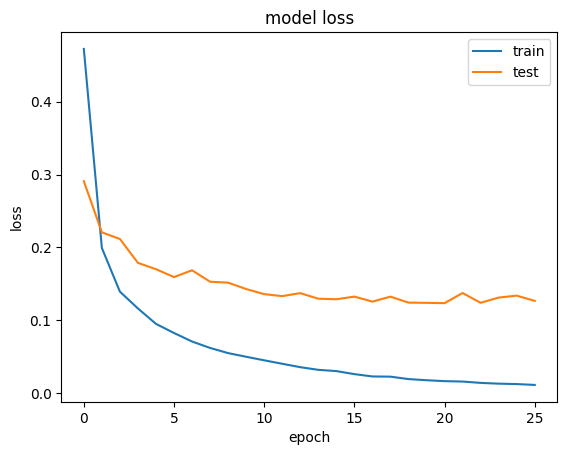

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

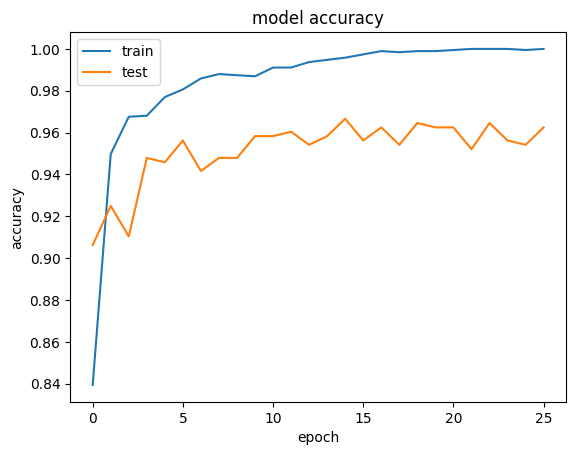

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("covid_classifier_model.json","w") as json_file:
  json_file.write(model_json)

## Evaluating the Saved Model Performance¶


In [ ]:
# Load pretrained model (best saved one)
with open('covid_classifier_model.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('covid_vgg16.h5')
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=opt, metrics= ["accuracy"])

In [ ]:
predictions = model.predict(X_test)


15/15 [==============================] - 7s 144ms/step


In [ ]:
predictions.shape


(480, 3)

In [ ]:
# Obtain the predicted class from the model prediction
predict = []

for i in predictions:
  predict.append(np.argmax(i))

predict = np.asarray(predict)

In [ ]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predict)
accuracy

0.9625

<Axes: >

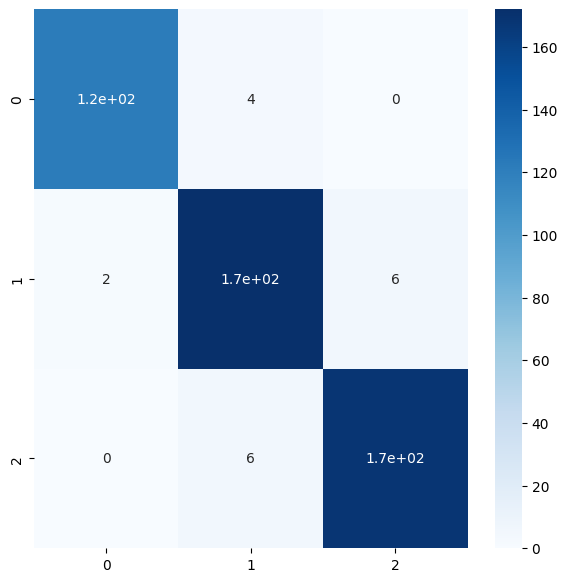

In [ ]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True, cmap='Blues')

# The model misclassified 8 virus as normal and 6 norma as virus and 2 normal as covid 


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predict)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       126
           1       0.95      0.96      0.95       180
           2       0.97      0.97      0.97       174

    accuracy                           0.96       480
   macro avg       0.96      0.96      0.96       480
weighted avg       0.96      0.96      0.96       480



# Interface

In [ ]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 KB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 K

In [ ]:
# # Loading the model
# from tensorflow import keras
# my_model = keras.models.load_model("/content/gdrive/MyDrive/My_models/chestXray_covid19_model.h5")
# print("Done ...")


In [ ]:
# https://www.gradio.app/ml_examples

import tensorflow as tf
from tensorflow import keras
import numpy as np
import gradio as gr
import requests
#from PIL import Image
import cv2

def inference(img):
    labels =["Covid19","Virus","Normal"]
    H,W,C = 256,256,3
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (H, W)) 
    img = np.array(img)
    img = img.astype("float32")/255.0
    img = img.reshape(1,H,W,C)
    pred = model.predict(img).flatten()
    # prediction = [pred[0], pred[1], pred[2]]
    # dictionary = dict(zip(labels, map(float, prediction)))
    return {labels[i]: float(pred[i]) for i in range(len(labels))}


nbr_top_classes = 3
gr.Interface(fn=inference, 
             inputs=gr.inputs.Image(), 
             outputs=gr.outputs.Label(num_top_classes=nbr_top_classes),
             theme="darkdefault"
             ).launch(share=True) #, debug=True Use in Colab


/usr/local/lib/python3.9/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.9/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)
/usr/local/lib/python3.9/dist-packages/gradio/blocks.py:528: UserWarning: Cannot load darkdefault. Caught Exception: The space darkdefault does not exist
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://efb078f63f203e6031.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
